In [1]:
import os
if os.path.basename(os.getcwd()) != 'Learning-Dynamic-Systems': os.chdir(".\..")

from optimal_controller.lowres_MVEE import LowResMVEE
from indirect_identification.sps_indirect import SPS_indirect_model
from indirect_identification.armax import ARMAX
from fusion.fusion import *
import numpy as np
import matplotlib.pyplot as plt
import os

# np.random.seed(42)

### Demonstrate fusion of two different confidence regions
##### Define an ARX system, generate input/output data

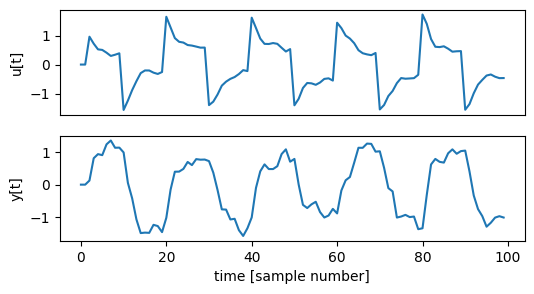

In [2]:
a = 0.8
b = 0.4
A = [1, -a]   # A(z^-1) = 1 - 0.33z^-1
B = [b]       # B(z^-1) = 0.22z^-1
C = [1, 0.15]    # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]          # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)
n_samples = 100
R = np.sign(np.sin(np.linspace(0, 10*np.pi, n_samples))) # square wave reference signal, works with both cupy and numpy
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,3))
ax = ax.flatten()
ax[0].plot(U)
ax[0].set_xticks([])
ax[0].set_ylabel('u[t]')
ax[1].plot(Y)
ax[1].set_ylabel('y[t]')
ax[1].set_xlabel('time [sample number]')
plt.show()

#####

In [3]:
F = ([0.31, 0.23], [1])
L = ([1], [1])
n_a = 1
n_b = 1

search_ranges = [[0.6, 1.0], [0.1, 0.7]] # a range, b range
search_resolutions = [64,64]
grid_axes = [np.linspace(search_ranges[i][0], search_ranges[i][1], search_resolutions[i]) for i in range(n_a+n_b)]
model = SPS_indirect_model(m=20, q=1)
ranks = get_ranks(grid_axes, model, n_a, n_b, C, L, F, Y, R)
ranks = np.round(ranks,3)

In [4]:
# the ranks tell you which percentage confidence region a point belongs to
# e.g. if the rank = 0.1 it belongs to the 10 pct confidence region

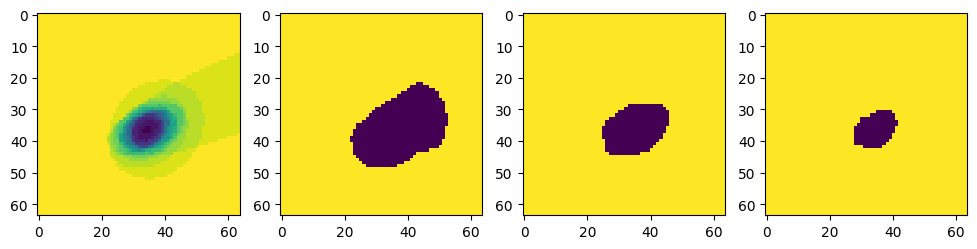

In [5]:
fig, axes = plt.subplots(1,4,figsize=(12,4))
axes[0].imshow(ranks)
axes[1].imshow(ranks >= 0.95) # this is the 95% confidence region - if you repeat the experiment over and over, the true parameter will be in this set 95% of the time
axes[2].imshow(ranks >= 0.8)
axes[3].imshow(ranks >= 0.5)
plt.show()

In [6]:
initial_pts = sample_fused_rank_tensor(ranks, grid_axes, p=0.95)
initial_pts.shape

(1070, 2)

0.75
0.5625
0.421875
0.4821428571428571


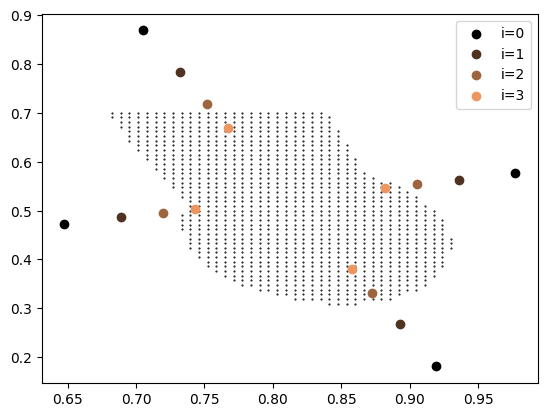

In [7]:
lrMVEE = LowResMVEE(initial_pts.T, max_n_verts=4)

c = lrMVEE.vertices.mean(axis=1)
c = c.reshape(2,1)
sf = 1
break_on_next = False

fig, ax = plt.subplots(1,1)
ax.scatter(lrMVEE.pts[0,:], lrMVEE.pts[1,:], marker='.', c='k', s=1)
# ax.scatter(lrMVEE.vertices[0,:], lrMVEE.vertices[1,:])
# ax.scatter(scaled_vertices[0,:], scaled_vertices[1,:])

for i in range(5):
    scaled_vertices = sf*(lrMVEE.vertices.copy() - c) + c

    vertices_in_conf_region = []
    all_vertices_in_conf_region = True
    for point in scaled_vertices.T:
        A = np.concatenate(([1], -point[:n_a]))
        B = np.concatenate(([0],  point[n_a:]))
        G = (B, A)
        H = (C, A)
        try:
            G_0, H_0 = model.transform_to_open_loop(G, H, F, L)
            in_sps, _ = model.open_loop_sps(G_0, H_0, Y, R, n_a, n_b)
            if in_sps:
                vertices_in_conf_region.append(point)
            else:
                all_vertices_in_conf_region = False

        except Exception as e:
            # Unstable open loop system - ignore this infeasible parameter combination
            all_vertices_in_conf_region = False
            pass
    
    if break_on_next and all_vertices_in_conf_region:
        # still too small, continue
        sf *= 8/7
        break_on_next = True
    elif break_on_next and not all_vertices_in_conf_region:
        break
    else:
        if all_vertices_in_conf_region:
            sf *= 8/7
            break_on_next = True
        else:
            sf *= 0.75

    print(sf)
    ax.scatter(scaled_vertices[0,:], scaled_vertices[1,:], label=f"i={i}")

cmap = plt.colormaps['copper']
colors = cmap(np.arange(0,i) / i)
for i2 in range(i):
    ax.collections[i2+1].set_color(colors[i2])

plt.legend()
plt.show()

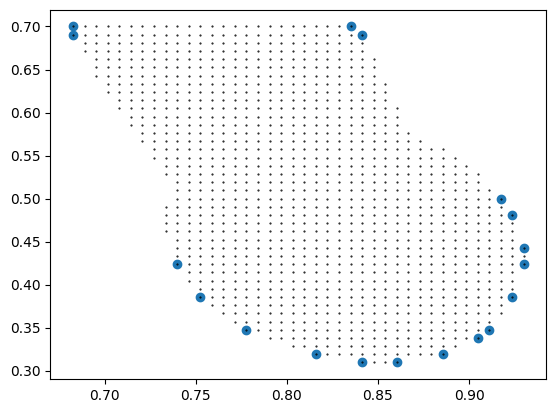

In [8]:
from scipy.spatial import ConvexHull

hull = ConvexHull(initial_pts)
hull_pts = initial_pts[hull.vertices,:]

fig, ax = plt.subplots(1,1)
ax.scatter(hull_pts[:,0], hull_pts[:,1])
ax.scatter(initial_pts[:,0], initial_pts[:,1], marker='.', c='k', s=1)
plt.show()